In [243]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<h2>Background</h2>

The goal of this project is to predict what type of bacteria is present in a mixed sample of two bacteria types.  Provided in the data are spectra of one type of bacteria per sample along with associated metadata.  Mixed spectra are also provided with metadata.

Regarding the dataset, it is connected with a paper that reports analysis with an approach based on a Lasso Regressor (Pierre Mahe, et al. "Automatic identification of mixed bacterial species fingerprints in a MALDI-TOF mass-spectrum" Bioinformatics. Vol. 30 no. 9 2014, pages 1280–1286).  This portion is about the pure spectra data:

"This MALDI-TOF dataset consists in: A) A reference panel of 20 Gram positive and negative bacterial species covering 9 genera among which several species are known to be hard to discriminate by mass spectrometry (MALDI-TOF). Each species was represented by 11 to 60 mass spectra obtained from 7 to 20 bacterial strains, constituting altogether a dataset of 571 spectra obtained from 213 strains. The spectra were obtained according to the standard culture-based workflow used in clinical routine in which the microorganism was first grown on an agar plate for 24 to 48 hours, before a portion of colony was picked, spotted on a MALDI slide and a mass spectrum was acquired."

<h2>Approach</h2>

Create a random forest model by training with pure sample spectra data and apply to mixed sample spectra to predict a component strain.

<h2>Use Random Forest to Predict Bacterial Strains in Samples</h2>

<h3>Input Pure Spectra Data</h3>

In [244]:
df_pure_spectra_matrix = pd.read_csv('pure_spectra_matrix.csv', delimiter=';')
print(df_pure_spectra_matrix.head())
print(len(df_pure_spectra_matrix))

   0  0.1  0.2  0.3  0.4  0.5  44431.921875  0.6  0.7  0.8   ...    \
0  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
1  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
2  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
3  0    0  0.0  0.0  0.0    0   4701.712402  0.0  0.0  0.0   ...     
4  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     

         0.1217  0.1218  0.1219  0.1220        0.1221  0.1222  0.1223  0.1224  \
0  27667.777344     0.0       0     0.0  35438.351562     0.0     0.0     0.0   
1  59820.968750     0.0       0     0.0   6384.590820     0.0     0.0     0.0   
2      0.000000     0.0       0     0.0      0.000000     0.0     0.0     0.0   
3   3913.969727     0.0       0     0.0      0.000000     0.0     0.0     0.0   
4      0.000000     0.0       0     0.0      0.000000     0.0     0.0     0.0   

   0.1225  0.1226  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0   

<h3>Plot three representative spectra of bacteria from pure samples.</h3>  
Note that two of the plots immediately below are from different samples (0, 10, 20) but two are of the same species (VVJ.KSF).

Transpose the dataframe to make compatible with plot.line()

In [245]:
df_pure_spectra_matrix_transposed = df_pure_spectra_matrix.T

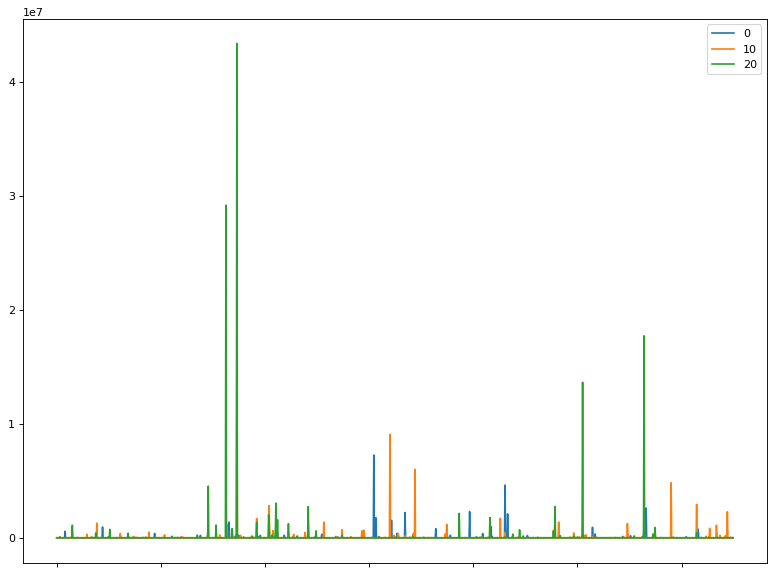

In [246]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_pure_spectra_matrix_transposed[0].plot.line(legend=True) # Species RTO.TQH
df_pure_spectra_matrix_transposed[10].plot.line(legend=True) # Species VVJ.KSF
df_pure_spectra_matrix_transposed[20].plot.line(legend=True) #Species VVJ.KSF

<h3>Check Pure Spectra Metadata</h3>

Note that the length of the metadata for the pure spectra is one greater than the actual spectra data (570 vs. 571)

In [247]:
df_pure_spectra_metadata = pd.read_csv('pure_spectra_metadata.csv', delimiter=';')
print(df_pure_spectra_metadata.head())
print("\n")
print("Length of pure spectra metadata: " + str(len(df_pure_spectra_metadata)))

   Species  Strain
0  RTO.TQH       1
1  BUT.YZE       2
2  BUT.YZE       2
3  BUT.YZE       2
4  BUT.YZE       2


Length of pure spectra metadata: 571


Note that Strain 214 is not in the pure spectra metadata, but it is shown in the mixed spectra metadata further below

In [248]:
print("Strain Count")
print(df_pure_spectra_metadata["Strain"].value_counts(ascending=True))
df_pure_spectra_metadata.loc[df_pure_spectra_metadata["Strain"] == 214]

Strain Count
1      1
28     1
166    1
32     1
160    1
159    1
37     1
152    1
149    1
86     1
135    1
130    1
128    1
60     1
61     1
65     1
71     1
103    1
93     1
79     1
87     1
81     1
170    1
171    1
85     1
11     1
19     1
13     1
205    1
204    1
      ..
77     4
90     4
88     4
27     4
52     4
120    4
84     4
168    4
31     4
164    4
161    4
157    4
155    4
154    4
150    4
51     4
107    4
145    4
141    4
138    4
137    4
47     4
131    4
198    5
49     5
211    5
7      6
126    6
66     6
188    6
Name: Strain, Length: 213, dtype: int64


,Species,Strain


<h3>Input Mixed Spectra Metadata and Check</h3>

From the paper related to this work:

"B) Based on this reference panel, a dedicated in vitro mock-up mixture dataset was constituted. For that purpose we considered 10 pairs of species of various taxonomic proximity:
* 4 mixtures, labelled A, B, C and D, involved species that belong to the same genus,
* 2 mixtures, labelled E and F, involved species that belong to distinct genera, but to the same Gram type,
* 4 mixtures, labelled G, H, I and J, involved species that belong to distinct Gram types.
Each mixture was represented by 2 pairs of strains, which were mixed according to the following 9 concentration ratios : 1:0, 10:1, 5:1, 2:1, 1:1, 1:2, 1:5, 1:10, 0:1. Two replicate spectra were acquired for each concentration ratio and each couple of strains, leading altogether to a dataset of 360 spectra, among which 80 are actually pure sample spectra."

In [249]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata.head())
print("\n")
print("Number of mixed spectra samples: " + str(len(df_mixed_spectra_metadata)))

  Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0             A           1   NYV.XSY       214   NYV.VCE        77   
1             A           1   NYV.XSY       214   NYV.VCE        77   
2             A           1   NYV.XSY       214   NYV.VCE        77   
3             A           1   NYV.XSY       214   NYV.VCE        77   
4             A           1   NYV.XSY       214   NYV.VCE        77   

   Replicate Ratio  Proportion  
0          1   1:0    1.000000  
1          2   1:0    1.000000  
2          1   2:1    0.666667  
3          2   2:1    0.666667  
4          1   5:1    0.838384  


Number of mixed spectra samples: 360


<h3>Input Mixed Spectra and Check</h3>

In [250]:
df_mixed_spectra_matrix = pd.read_csv('mixed_spectra_matrix.csv', delimiter=';', header=None)
print(df_mixed_spectra_matrix.head())
print("\n")
print("Number of mixed spectra (80 are actually pure sample spectra):")
print(len(df_mixed_spectra_matrix))

   0     1     2     3     4     5     6     7     8             9     \
0     0   0.0   0.0   0.0   0.0     0   0.0   0.0   0.0      0.000000   
1     0   0.0   0.0   0.0   0.0     0   0.0   0.0   0.0  10162.613281   
2     0   0.0   0.0   0.0   0.0     0   0.0   0.0   0.0      0.000000   
3     0   0.0   0.0   0.0   0.0     0   0.0   0.0   0.0      0.000000   
4     0   0.0   0.0   0.0   0.0     0   0.0   0.0   0.0  15409.125977   

       ...       1290  1291  1292  1293  1294  1295          1296  1297  1298  \
0      ...        0.0     0     0   0.0   0.0   0.0      0.000000   0.0   0.0   
1      ...        0.0     0     0   0.0   0.0   0.0  11427.124023   0.0   0.0   
2      ...        0.0     0     0   0.0   0.0   0.0  12094.415039   0.0   0.0   
3      ...        0.0     0     0   0.0   0.0   0.0      0.000000   0.0   0.0   
4      ...        0.0     0     0   0.0   0.0   0.0      0.000000   0.0   0.0   

           1299  
0      0.000000  
1      0.000000  
2      0.000000  
3 

<h3>Plot of Three Spectra of Bacteria from Mixed Samples</h3>

Transpose data matrix to generate plot

In [251]:
df_mixed_spectra_matrix_transposed = df_mixed_spectra_matrix.T

Mixed samples 0, 10, and 20 are plotted below. There is some overlap of signals but not a high degree.

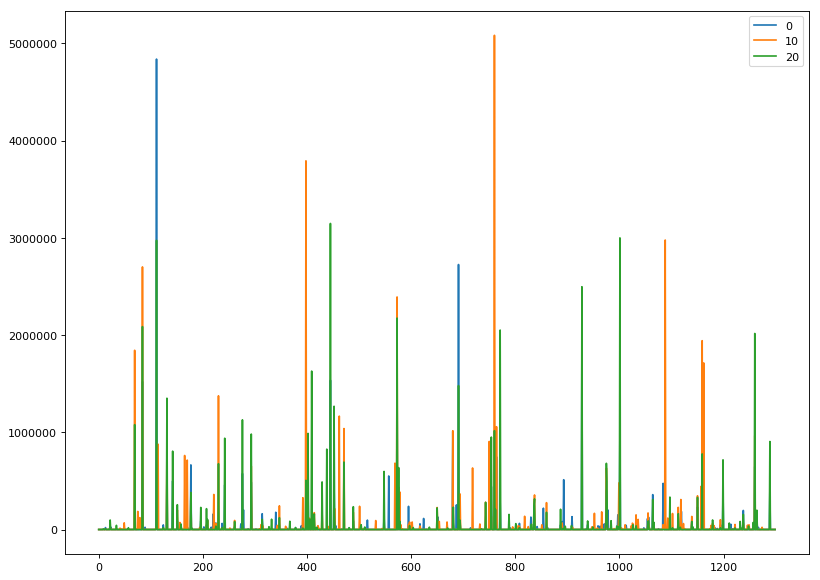

In [252]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[0].plot.line(legend=True)
df_mixed_spectra_matrix_transposed[10].plot.line(legend=True)
df_mixed_spectra_matrix_transposed[20].plot.line(legend=True)

<h3>Input Mixed Spectra Metadata</h3>

In [253]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata.head(20))
print("\n")
print("Number of mixed spectra (80 are actually pure sample spectra):")
print(len(df_mixed_spectra_metadata))
#Notice that the ratio indicates whether a strain is present or not

   Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0              A           1   NYV.XSY       214   NYV.VCE        77   
1              A           1   NYV.XSY       214   NYV.VCE        77   
2              A           1   NYV.XSY       214   NYV.VCE        77   
3              A           1   NYV.XSY       214   NYV.VCE        77   
4              A           1   NYV.XSY       214   NYV.VCE        77   
5              A           1   NYV.XSY       214   NYV.VCE        77   
6              A           1   NYV.XSY       214   NYV.VCE        77   
7              A           1   NYV.XSY       214   NYV.VCE        77   
8              A           1   NYV.XSY       214   NYV.VCE        77   
9              A           1   NYV.XSY       214   NYV.VCE        77   
10             A           1   NYV.XSY       214   NYV.VCE        77   
11             A           1   NYV.XSY       214   NYV.VCE        77   
12             A           1   NYV.XSY       214   NYV.VCE      

<h2>Examples of mixed spectra with pure spectra</h2>
<h3>First example</h3>

It is interesting to note that, in the plot below, some of the data from the pure samples' spectra overlap (see Samples 194 and 202)

There does appear to be overlap with the pure spectra and the related mixed spectra at some of the small peaks, but not as much the large peaks.

I would like to investigate this further (whether there are small signals that overlap) especially if the results do not meet expectations.

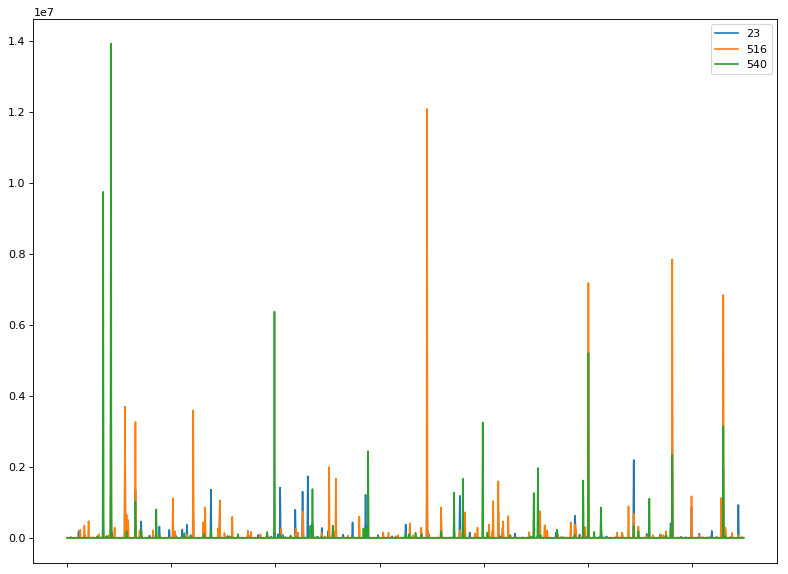

In [254]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[23].plot.line(legend=True)
df_pure_spectra_matrix_transposed[516].plot.line(legend=True) #516 is Sample 194
df_pure_spectra_matrix_transposed[540].plot.line(legend=True) #540 is Sample 202

<h3>Second Example</h3>

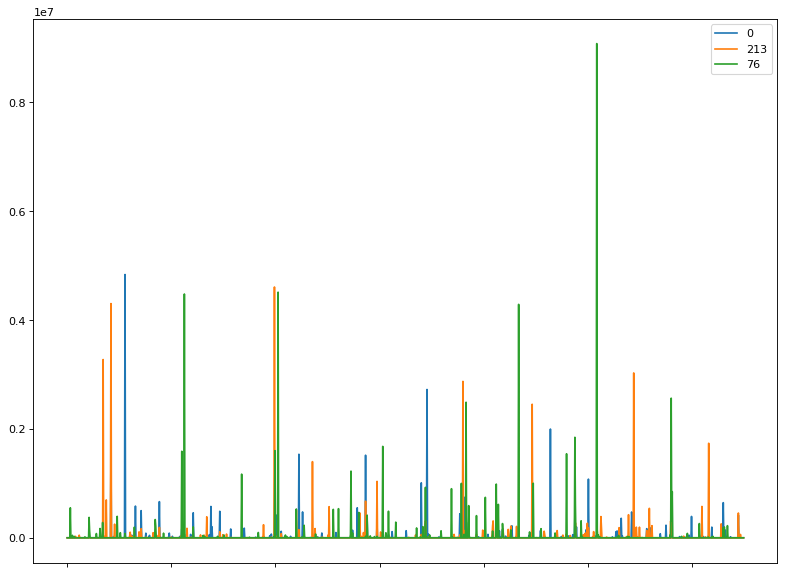

In [255]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

df_mixed_spectra_matrix_transposed[0].plot.line(legend=True)
df_pure_spectra_matrix_transposed[213].plot.line(legend=True)
df_pure_spectra_matrix_transposed[76].plot.line(legend=True)

In [256]:
X_train = df_pure_spectra_matrix
X_test = df_mixed_spectra_matrix

<h2>Random forest classifier to predict strain (not accounting for zero proportion)</h2>

This is to see whether a set of data can be used for training to generate a model to predict species.  This code is based on an example from http://benalexkeen.com/random-forests-in-python-using-scikit-learn/

In [257]:
xTrain, xTest, yTrain, yTest = train_test_split(X_train, df_pure_spectra_metadata["Species"][0:570], test_size = 0.2, random_state = 10)

clf = RandomForestClassifier(n_estimators=100, bootstrap="True", max_depth=None, min_samples_split=5, 
                             min_impurity_decrease=1e-5, random_state=10, max_features="auto")
clf.fit(xTrain, yTrain)

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-05, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

Accuracy of predictions with training data is understandably high

In [258]:
yPredict = clf.predict(xTrain)
accuracy_score(yTrain, yPredict)

0.9956140350877193

The test set of data yields ~64% accuracy

In [259]:
yPredict = clf.predict(xTest)
accuracy_score(yTest, yPredict)

0.6403508771929824

This is to show an example of data predicted from the model

In [260]:
print(yPredict[0])

NYV.VCE


This is a naive test without removing samples that have zero proportion in the mixed sample

In [261]:
clf = RandomForestClassifier(n_estimators=100, bootstrap="True", max_depth=None, min_samples_split=5, 
                             min_impurity_decrease=1e-7, random_state=10, max_features="auto")
clf.fit(X_train, df_pure_spectra_metadata["Species"][0:570])

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [262]:
Y_predict = clf.predict(X_test)
print("Accuracy of Predicting Species 1 (Naive):")
print(accuracy_score(Y_predict, df_mixed_spectra_metadata["Species_1"][0:360]))
print("Accuracy of Predicting Species 2 (Naive):")
print(accuracy_score(Y_predict, df_mixed_spectra_metadata["Species_2"][0:360]))

Accuracy of Predicting Species 1 (Naive):
0.39166666666666666
Accuracy of Predicting Species 2 (Naive):
0.5805555555555556


This showcases the matching of the actual sample with the predicted sample

In [263]:
print("Actual  Predicted")
for i in range(360):
    print(df_mixed_spectra_metadata["Species_1"][i] + ' ' + Y_predict[i])

Actual  Predicted
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.XSY
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
NYV.XSY NYV.VCE
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.HSS
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AEX AUG.AEX
AUG.AE

<h3>Confusion Matrix for Strain 1</h3>

This is the confusion matrix of the naive test for comparison of predicted strain with Strain 1:

In [264]:
print("The columns are the predicted labels, and the rows are the true labels")
labels = np.unique(Y_predict)
a =  confusion_matrix(df_mixed_spectra_metadata["Species_1"][0:360], Y_predict, labels=labels)
pd.DataFrame(a, index=labels, columns=labels)

The columns are the predicted labels, and the rows are the true labels


,AUG.AEX,AUG.HSS,BUT.DNW,BUT.TRH,BUT.YZE,EMD.FZO,JNH.FLH,JNH.ZIJ,NYV.VCE,NYV.XSY,QBG.CRP,QWP.DRH,RTO.JFR,VVJ.KSF,VVJ.KWJ
AUG.AEX,55,6,11,0,0,0,0,0,0,0,0,0,0,0,0
AUG.HSS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.DNW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.TRH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.YZE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EMD.FZO,26,0,0,0,0,10,0,0,0,0,0,0,0,0,0
JNH.FLH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JNH.ZIJ,0,0,0,0,0,0,25,11,0,0,0,0,0,0,0
NYV.VCE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NYV.XSY,0,0,0,0,0,0,0,0,26,10,0,0,0,0,0


<h3>Confusion Matrix for Strain 2</h3>

This is the confusion matrix of the naive test for comparison of predicted strain with Strain 2:

In [265]:
print("The columns are the predicted labels, and the rows are the true labels")
labels = np.unique(Y_predict)
a =  confusion_matrix(df_mixed_spectra_metadata["Species_2"][0:360], Y_predict, labels=labels)
pd.DataFrame(a, index=labels, columns=labels)

The columns are the predicted labels, and the rows are the true labels


,AUG.AEX,AUG.HSS,BUT.DNW,BUT.TRH,BUT.YZE,EMD.FZO,JNH.FLH,JNH.ZIJ,NYV.VCE,NYV.XSY,QBG.CRP,QWP.DRH,RTO.JFR,VVJ.KSF,VVJ.KWJ
AUG.AEX,26,0,0,0,0,10,0,0,0,0,0,0,0,0,0
AUG.HSS,30,6,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.DNW,25,0,11,0,0,0,0,0,0,0,0,0,0,0,0
BUT.TRH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.YZE,0,0,4,4,55,0,0,0,0,0,4,5,0,0,0
EMD.FZO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JNH.FLH,0,0,0,0,0,0,25,11,0,0,0,0,0,0,0
JNH.ZIJ,0,0,0,0,0,0,0,15,0,0,0,0,0,2,19
NYV.VCE,0,0,0,0,0,0,0,0,54,10,0,0,8,0,0
NYV.XSY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h3>Accounting for Zero Proportion</h3>

Any proportion of sample greater than zero contains "Strain 1."  Use the indexing on "df_mixed_spectra_metadata" with equality test to find predictions on "Strain 1."  The same logic applies to find when "Strain 2" is present

In [266]:
Y_predict[df_mixed_spectra_metadata["Proportion"]>0]
#Y_predict[df_mixed_spectra_metadata["Proportion"]<1]

array(['NYV.XSY', 'NYV.XSY', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE',
       'NYV.XSY', 'NYV.XSY', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE',
       'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.XSY', 'NYV.XSY',
       'NYV.VCE', 'NYV.VCE', 'NYV.XSY', 'NYV.XSY', 'NYV.XSY', 'NYV.XSY',
       'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE', 'NYV.VCE',
       'NYV.VCE', 'NYV.VCE', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX',
       'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX',
       'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX',
       'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX',
       'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.AEX', 'AUG.HSS', 'AUG.HSS',
       'AUG.AEX', 'AUG.HSS', 'AUG.AEX', 'AUG.AEX', 'JNH.FLH', 'JNH.FLH',
       'JNH.FLH', 'JNH.ZIJ', 'JNH.ZIJ', 'JNH.ZIJ', 'JNH.ZIJ', 'JNH.ZIJ',
       'JNH.FLH', 'JNH.FLH', 'JNH.FLH', 'JNH.FLH', 'JNH.FLH', 'JNH.FLH',
       'JNH.FLH', 'JNH.FLH', 'JNH.ZIJ', 'JNH.ZIJ', 

Demonstrate that the comparison between the predicted strain and the actual strain is possible with this indexing:

In [267]:
#df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]>0][0:360]["Species_1"] == Y_predict[df_mixed_spectra_metadata["Proportion"]>0]
df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]<1][0:360]["Species_2"] == Y_predict[df_mixed_spectra_metadata["Proportion"]<1]

2       True
3       True
4       True
5       True
6      False
7      False
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
20      True
21      True
22     False
23     False
24     False
25     False
26      True
27      True
28      True
29      True
30      True
31      True
32      True
33      True
       ...  
328    False
329    False
330    False
331    False
332    False
333    False
334     True
335     True
336     True
337    False
338    False
339    False
340     True
341     True
344    False
345    False
346    False
347    False
348    False
349    False
350    False
351    False
352     True
353     True
354     True
355     True
356    False
357    False
358     True
359     True
Name: Species_2, Length: 320, dtype: bool

<h2> Accuracy of Predictions on Species 1 and Species 2 </h2>

Print the accuracy score and notice that it is greater than the naive test:

In [268]:
print("Accuracy of predicting Strain 1:")
print(accuracy_score(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]>0][0:360]["Species_1"],Y_predict[df_mixed_spectra_metadata["Proportion"]>0]))
print("Accuracy of predicting Strain 2:")
print(accuracy_score(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]<1][0:360]["Species_2"], Y_predict[df_mixed_spectra_metadata["Proportion"]<1]))

Accuracy of predicting Strain 1:
0.4375
Accuracy of predicting Strain 2:
0.646875


<h2> The Confusion Matrix for Strain 1 and Strain 2 </h2>

<h3>Strain 1 Confusion Matrix</h3>

In [269]:
print("The columns are the predicted labels, and the rows are the true labels")
labels = np.unique(Y_predict[df_mixed_spectra_metadata["Proportion"]>0])
a =  confusion_matrix(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]>0][0:360]["Species_1"], Y_predict[df_mixed_spectra_metadata["Proportion"]>0], labels=labels)
pd.DataFrame(a, index=labels, columns=labels)

The columns are the predicted labels, and the rows are the true labels


,AUG.AEX,AUG.HSS,BUT.DNW,BUT.TRH,BUT.YZE,EMD.FZO,JNH.FLH,JNH.ZIJ,NYV.VCE,NYV.XSY,QBG.CRP,QWP.DRH,RTO.JFR,VVJ.KSF,VVJ.KWJ
AUG.AEX,54,3,7,0,0,0,0,0,0,0,0,0,0,0,0
AUG.HSS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.DNW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.TRH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.YZE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EMD.FZO,22,0,0,0,0,10,0,0,0,0,0,0,0,0,0
JNH.FLH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JNH.ZIJ,0,0,0,0,0,0,21,11,0,0,0,0,0,0,0
NYV.VCE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NYV.XSY,0,0,0,0,0,0,0,0,22,10,0,0,0,0,0


<h3>Strain 2 Confusion Matrix</h3>

In [270]:
print("The columns are the predicted labels, and the rows are the true labels")
labels = np.unique(Y_predict[df_mixed_spectra_metadata["Proportion"]<1])
a =  confusion_matrix(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]<1][0:360]["Species_2"], Y_predict[df_mixed_spectra_metadata["Proportion"]<1], labels=labels)
pd.DataFrame(a, index=labels, columns=labels)

The columns are the predicted labels, and the rows are the true labels


,AUG.AEX,AUG.HSS,BUT.DNW,BUT.TRH,BUT.YZE,EMD.FZO,JNH.FLH,JNH.ZIJ,NYV.VCE,NYV.XSY,QWP.DRH,RTO.JFR,VVJ.KSF,VVJ.KWJ
AUG.AEX,26,0,0,0,0,6,0,0,0,0,0,0,0,0
AUG.HSS,26,6,0,0,0,0,0,0,0,0,0,0,0,0
BUT.DNW,21,0,11,0,0,0,0,0,0,0,0,0,0,0
BUT.TRH,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BUT.YZE,0,0,4,4,55,0,0,0,0,0,1,0,0,0
EMD.FZO,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JNH.FLH,0,0,0,0,0,0,23,9,0,0,0,0,0,0
JNH.ZIJ,0,0,0,0,0,0,0,15,0,0,0,0,2,15
NYV.VCE,0,0,0,0,0,0,0,0,54,6,0,4,0,0
NYV.XSY,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h3> Graphical Display of the Confusion Matrix </h3>

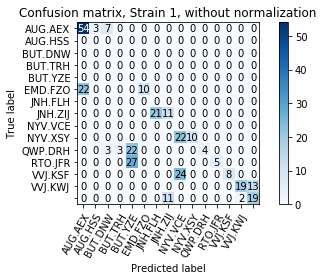

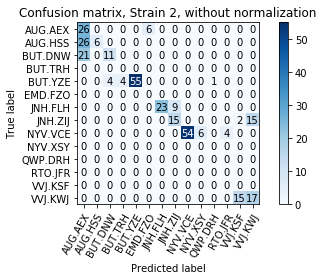

In [271]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          labels=None,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]>0][0:360]["Species_1"],
                      Y_predict[df_mixed_spectra_metadata["Proportion"]>0],
                      normalize=False,
                      labels=labels,
                      title='Confusion matrix, Strain 1, without normalization')

plot_confusion_matrix(df_mixed_spectra_metadata[df_mixed_spectra_metadata["Proportion"]<1][0:360]["Species_2"],
                      Y_predict[df_mixed_spectra_metadata["Proportion"]<1],
                      normalize=False,
                      labels=labels,
                      title='Confusion matrix, Strain 2, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(df_mixed_spectra_metadata["Species_2"][0:570], Y_predict, normalize=True,
 #                     title='Normalized confusion matrix')

plt.show()

<h2>Summary</h2>

This analysis shows that there are a few strains that are particularly well predicted especially from Strain 2 samples.

The authors of the paper pioneering analysis on this data and simulated data reported: "Few spectra were misidentified and mixtures were always at least partially identified. More than 60% of the mixtures were detected and correctly identified."

Our model would need to be modified to try to predict both bacteria types in the mixed samples as there is only one species in this work predicted per mixed sample.